# Step 0: Project Setup and Environment

First, we'll install all the necessary Python libraries. This notebook assumes you are running it in an environment like Google Colab or a local Jupyter setup where you can install packages.

In [ ]:
!pip install torch torchvision torchaudio scikit-learn pandas opencv-python-headless matplotlib tqdm deap Pillow albumentations

# Step 1: Get the Data

For this project, we need a dataset of blood smear images. A common public dataset is the **ALL-IDB (Acute Lymphoblastic Leukemia Image Database)**. We'll download a version of it that is already structured into folders by class.

Let's download and unzip the data.

In [ ]:
!wget https://storage.googleapis.com/leukemia-public-data/leukemia_dataset_small.zip
!unzip -q leukemia_dataset_small.zip

Now, let's set up our project directory structure. This helps keep our raw data, processed data, and models organized.

In [14]:
import os
from pathlib import Path

# Define the absolute path to your project's root directory
PROJECT_ROOT = Path('/Users/adarshainamdar/Documents/Major_Project')
PROJECT_ROOT.mkdir(parents=True, exist_ok=True) # Ensure the root exists

# The raw data is downloaded to the current working directory of the notebook
DATA_DIR = Path('leukemia_dataset_small')

# Define all output paths relative to your specified project root
OUTPUTS_DIR = PROJECT_ROOT / 'outputs'
DATA_OUTPUT_DIR = PROJECT_ROOT / 'data' 
PROCESSED_DIR = DATA_OUTPUT_DIR / 'processed'
TRAIN_DIR = DATA_OUTPUT_DIR / 'train'
VAL_DIR = DATA_OUTPUT_DIR / 'val'
TEST_DIR = DATA_OUTPUT_DIR / 'test'
MODEL_DIR = OUTPUTS_DIR / 'models'
LOG_DIR = OUTPUTS_DIR / 'logs'

# Create directories
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
TRAIN_DIR.mkdir(parents=True, exist_ok=True)
VAL_DIR.mkdir(parents=True, exist_ok=True)
TEST_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

print(f"Reading raw data from: {DATA_DIR.resolve()}")
print(f"All outputs (logs, models, processed data) will be saved in: {PROJECT_ROOT.resolve()}")

Reading raw data from: /Users/adarshainamdar/Documents/Major_Project/leukemia_dataset_small
All outputs (logs, models, processed data) will be saved in: /Users/adarshainamdar/Documents/Major_Project


### Logging Setup

To keep track of our experiments, we'll set up a logging system. This will save all our training progress, results, and hyperparameters to a file (`training.log`), which is crucial for reproducibility and debugging.

In [15]:
import logging

LOG_FILE = LOG_DIR / 'training.log'

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(LOG_FILE, mode='w'), # Overwrite log file each run
        logging.StreamHandler() # Also print to console
    ]
)

logging.info(f"Logging setup complete. Log file will be saved to: {LOG_FILE.resolve()}")

2025-09-04 12:03:52,837 - INFO - Logging setup complete. Log file will be saved to: /Users/adarshainamdar/Documents/Major_Project/outputs/logs/training.log


# Step 2: Clean & Resize Pictures

Deep learning models require images to be of a consistent size. We will resize all our images to 224x224 pixels, which is a standard size for many pre-trained models like ResNet.

In [16]:
import cv2
import glob
from tqdm import tqdm

IMAGE_SIZE = 224
CLASSES = ['ALL', 'AML', 'CLL', 'CML'] # Adjust if your classes are different

logging.info("Starting image preprocessing...")
for cls in CLASSES:
    in_dir = DATA_DIR / cls
    out_dir = PROCESSED_DIR / cls
    out_dir.mkdir(parents=True, exist_ok=True)
    
    image_paths = glob.glob(str(in_dir / '*.jpg')) + glob.glob(str(in_dir / '*.png'))
    
    logging.info(f"Processing class: {cls}, {len(image_paths)} images found.")
    for fp in tqdm(image_paths, desc=f"Processing {cls}"):
        img = cv2.imread(fp)
        if img is None:
            logging.warning(f"Could not read image: {fp}")
            continue
        
        # Resize the image
        img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)
        
        # Save the processed image
        cv2.imwrite(str(out_dir / Path(fp).name), img_resized)
        
logging.info("Image preprocessing complete.")

2025-09-04 12:03:59,123 - INFO - Starting image preprocessing...
2025-09-04 12:03:59,126 - INFO - Processing class: ALL, 0 images found.
Processing ALL: 0it [00:00, ?it/s]
2025-09-04 12:03:59,129 - INFO - Processing class: AML, 0 images found.
Processing AML: 0it [00:00, ?it/s]
2025-09-04 12:03:59,133 - INFO - Processing class: CLL, 0 images found.
Processing CLL: 0it [00:00, ?it/s]
2025-09-04 12:03:59,135 - INFO - Processing class: CML, 0 images found.
Processing CML: 0it [00:00, ?it/s]
2025-09-04 12:03:59,137 - INFO - Image preprocessing complete.


# Step 3: Split into Train / Validation / Test Sets

We need to split our data to properly train and evaluate our model. A common split is 70% for training, 15% for validation (tuning), and 15% for testing (final evaluation).

In [17]:
import random
import shutil

random.seed(42) # for reproducibility

logging.info("Splitting data into train, validation, and test sets.")
for cls in CLASSES:
    files = list((PROCESSED_DIR / cls).glob('*.*'))
    random.shuffle(files)
    
    n = len(files)
    n_train = int(0.7 * n)
    n_val = int(0.15 * n)
    
    train_files = files[:n_train]
    val_files = files[n_train : n_train + n_val]
    test_files = files[n_train + n_val:]
    logging.info(f"{cls}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")
    
    # Create subdirectories for each split
    (TRAIN_DIR / cls).mkdir(exist_ok=True)
    (VAL_DIR / cls).mkdir(exist_ok=True)
    (TEST_DIR / cls).mkdir(exist_ok=True)
    
    # Copy files
    for f in train_files: shutil.copy2(f, TRAIN_DIR / cls / f.name)
    for f in val_files: shutil.copy2(f, VAL_DIR / cls / f.name)
    for f in test_files: shutil.copy2(f, TEST_DIR / cls / f.name)

logging.info("Data splitting complete.")

2025-09-04 12:04:03,408 - INFO - Splitting data into train, validation, and test sets.
2025-09-04 12:04:03,412 - INFO - ALL: 224 train, 48 val, 48 test
2025-09-04 12:04:03,565 - INFO - AML: 224 train, 48 val, 48 test
2025-09-04 12:04:03,733 - INFO - CLL: 224 train, 48 val, 48 test
2025-09-04 12:04:03,887 - INFO - CML: 224 train, 48 val, 48 test
2025-09-04 12:04:04,034 - INFO - Data splitting complete.


# Step 4: Make a Simple "Baseline" Robot (Transfer Learning)

We'll start with a powerful pre-trained model, `ResNet18`, and fine-tune it for our specific task of leukemia classification. This is called **transfer learning** and is much more effective than training a model from scratch.

### Setup DataLoaders

In [18]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# Data augmentation and normalization for training
tfm_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation and testing
tfm_eval = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_ds = datasets.ImageFolder(str(TRAIN_DIR), tfm_train)
val_ds = datasets.ImageFolder(str(VAL_DIR), tfm_eval)
test_ds = datasets.ImageFolder(str(TEST_DIR), tfm_eval)

# Create data loaders
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

logging.info(f"Training samples: {len(train_ds)}")
logging.info(f"Validation samples: {len(val_ds)}")
logging.info(f"Test samples: {len(test_ds)}")
logging.info(f"Classes: {train_ds.classes}")

2025-09-04 12:04:06,226 - INFO - Training samples: 896
2025-09-04 12:04:06,228 - INFO - Validation samples: 192
2025-09-04 12:04:06,228 - INFO - Test samples: 192
2025-09-04 12:04:06,229 - INFO - Classes: ['ALL', 'AML', 'CLL', 'CML']


### Define and Train the Baseline Model

In [19]:
import torch.nn as nn
import torch.optim as optim

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    logging.info(f"Starting baseline model training for {num_epochs} epochs on {device}.")
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)
        
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
        logging.info(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')
        
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), MODEL_DIR / 'baseline_cls.pt')
            logging.info(f"New best model saved with validation accuracy: {best_val_acc:.4f}")
    
    logging.info("Finished baseline model training.")
    return model

# Setup the baseline model
baseline_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = baseline_model.fc.in_features
baseline_model.fc = nn.Linear(num_ftrs, len(CLASSES))

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(baseline_model.parameters(), lr=0.001)

# Train the model
trained_baseline = train_model(baseline_model, criterion, optimizer, train_dl, val_dl, num_epochs=10)

2025-09-04 12:04:09,309 - INFO - Starting baseline model training for 10 epochs on cpu.
Epoch 1/10 [Train]: 100%|██████████| 28/28 [00:50<00:00,  1.79s/it]
2025-09-04 12:05:03,795 - INFO - Epoch 1/10 | Train Loss: 1.1471 Acc: 0.5056 | Val Loss: 1.2415 Acc: 0.5260
2025-09-04 12:05:03,833 - INFO - New best model saved with validation accuracy: 0.5260
Epoch 2/10 [Train]: 100%|██████████| 28/28 [00:50<00:00,  1.79s/it]
2025-09-04 12:05:58,196 - INFO - Epoch 2/10 | Train Loss: 0.8537 Acc: 0.6239 | Val Loss: 0.7685 Acc: 0.7031
2025-09-04 12:05:58,236 - INFO - New best model saved with validation accuracy: 0.7031
Epoch 3/10 [Train]: 100%|██████████| 28/28 [01:24<00:00,  3.00s/it]
2025-09-04 12:07:26,619 - INFO - Epoch 3/10 | Train Loss: 0.7270 Acc: 0.6830 | Val Loss: 0.8287 Acc: 0.6250
Epoch 4/10 [Train]: 100%|██████████| 28/28 [00:48<00:00,  1.73s/it]
2025-09-04 12:08:19,337 - INFO - Epoch 4/10 | Train Loss: 0.7722 Acc: 0.6685 | Val Loss: 1.1700 Acc: 0.5156
Epoch 5/10 [Train]: 100%|█████████

# Step 5: Add the Grading Head (Multi-Task Model)

Now we'll create a more advanced model. It will have one shared 'backbone' (ResNet18) to understand the image features, but two separate 'heads' to make predictions:
1.  **Classification Head**: Predicts the leukemia type (ALL, AML, etc.).
2.  **Grading Head**: Predicts the severity (Chronic, Accelerated, Blast).

**Note:** Since we don't have real grading labels in this public dataset, we will simulate them for this example. In your actual project, you would need a dataset with both type and grade labels.

In [20]:
class MultiTaskModel(nn.Module):
    def __init__(self, n_types, n_grades):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        d_model = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity() # Remove the final layer of ResNet
        
        # Heads
        self.head_type = nn.Linear(d_model, n_types)
        self.head_grade = nn.Linear(d_model, n_grades)
        
    def forward(self, x):
        features = self.backbone(x)
        type_logits = self.head_type(features)
        grade_logits = self.head_grade(features)
        return type_logits, grade_logits

# For this example, we need to create a custom dataset that returns two labels.
GRADES = ['Chronic', 'Accelerated', 'Blast']
grade_map = {cls: i % len(GRADES) for i, cls in enumerate(CLASSES)}

class MultiTaskDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        path, type_label = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        
        # Get the class name and map it to a grade label (simulated)
        class_name = self.classes[type_label]
        grade_label = grade_map[class_name]
        
        return sample, type_label, grade_label

# Create new multi-task datasets and loaders
mt_train_ds = MultiTaskDataset(str(TRAIN_DIR), tfm_train)
mt_val_ds = MultiTaskDataset(str(VAL_DIR), tfm_eval)
mt_train_dl = DataLoader(mt_train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
mt_val_dl = DataLoader(mt_val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Instantiate the model
multitask_model = MultiTaskModel(n_types=len(CLASSES), n_grades=len(GRADES))
logging.info("Multi-task model and datasets created.")

2025-09-04 12:17:30,211 - INFO - Multi-task model and datasets created.


### Training the Multi-Task Model

Training this model is slightly different because we need to calculate two losses (one for classification, one for grading) and combine them.

In [21]:
def train_multitask_model(model, type_criterion, grade_criterion, optimizer, train_loader, val_loader, num_epochs=10, grade_loss_weight=0.5):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    logging.info(f"Starting multi-task model training for {num_epochs} epochs on {device}.")
    
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        total_loss_sum = 0.0
        for inputs, type_labels, grade_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            inputs, type_labels, grade_labels = inputs.to(device), type_labels.to(device), grade_labels.to(device)
            optimizer.zero_grad()
            type_logits, grade_logits = model(inputs)
            
            loss_type = type_criterion(type_logits, type_labels)
            loss_grade = grade_criterion(grade_logits, grade_labels)
            
            total_loss = loss_type + grade_loss_weight * loss_grade
            
            total_loss.backward()
            optimizer.step()
            total_loss_sum += total_loss.item() * inputs.size(0)

        avg_train_loss = total_loss_sum / len(train_loader.dataset)
        
        # Validation loop
        model.eval()
        total_type_correct = 0
        total_grade_correct = 0
        with torch.no_grad():
            for inputs, type_labels, grade_labels in val_loader:
                inputs, type_labels, grade_labels = inputs.to(device), type_labels.to(device), grade_labels.to(device)
                type_logits, grade_logits = model(inputs)
                
                _, type_preds = torch.max(type_logits, 1)
                _, grade_preds = torch.max(grade_logits, 1)
                
                total_type_correct += torch.sum(type_preds == type_labels.data)
                total_grade_correct += torch.sum(grade_preds == grade_labels.data)

        type_acc = total_type_correct.double() / len(val_loader.dataset)
        grade_acc = total_grade_correct.double() / len(val_loader.dataset)
        logging.info(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Type Acc: {type_acc:.4f}, Val Grade Acc: {grade_acc:.4f}')
        
        if type_acc > best_val_acc:
            best_val_acc = type_acc
            torch.save(model.state_dict(), MODEL_DIR / 'multitask_model.pt')
            logging.info(f"New best multi-task model saved with validation type accuracy: {best_val_acc:.4f}")
    
    logging.info("Finished multi-task model training.")

# Setup for multi-task training
type_criterion = nn.CrossEntropyLoss()
grade_criterion = nn.CrossEntropyLoss()
mt_optimizer = optim.AdamW(multitask_model.parameters(), lr=0.001)

# Train
train_multitask_model(multitask_model, type_criterion, grade_criterion, mt_optimizer, mt_train_dl, mt_val_dl, num_epochs=10)

2025-09-04 12:17:33,554 - INFO - Starting multi-task model training for 10 epochs on cpu.
Epoch 1/10 [Train]: 100%|██████████| 28/28 [00:48<00:00,  1.74s/it]
2025-09-04 12:18:26,478 - INFO - Epoch 1/10 | Train Loss: 1.6165 | Val Type Acc: 0.6250, Val Grade Acc: 0.6302
2025-09-04 12:18:26,543 - INFO - New best multi-task model saved with validation type accuracy: 0.6250
Epoch 2/10 [Train]: 100%|██████████| 28/28 [00:49<00:00,  1.76s/it]
2025-09-04 12:19:20,274 - INFO - Epoch 2/10 | Train Loss: 1.2147 | Val Type Acc: 0.6094, Val Grade Acc: 0.6198
Epoch 3/10 [Train]: 100%|██████████| 28/28 [00:49<00:00,  1.77s/it]
2025-09-04 12:20:14,105 - INFO - Epoch 3/10 | Train Loss: 1.2620 | Val Type Acc: 0.6406, Val Grade Acc: 0.6667
2025-09-04 12:20:14,149 - INFO - New best multi-task model saved with validation type accuracy: 0.6406
Epoch 4/10 [Train]: 100%|██████████| 28/28 [00:48<00:00,  1.73s/it]
2025-09-04 12:21:07,063 - INFO - Epoch 4/10 | Train Loss: 1.0992 | Val Type Acc: 0.6562, Val Grade 

# Step 6: Measure How Good It Is (Evaluation)

After training, we must evaluate our best model on the unseen test set to get a final, unbiased measure of its performance. We'll calculate accuracy, precision, recall, F1-score, and a confusion matrix.

2025-09-04 12:26:53,902 - INFO - --- Evaluating Baseline Model on Test Set ---
2025-09-04 12:26:58,192 - INFO - --- Classification Report ---
2025-09-04 12:26:58,197 - INFO - 
              precision    recall  f1-score   support

         ALL       0.96      1.00      0.98        48
         AML       0.67      0.42      0.51        48
         CLL       0.71      0.52      0.60        48
         CML       0.45      0.73      0.56        48

    accuracy                           0.67       192
   macro avg       0.70      0.67      0.66       192
weighted avg       0.70      0.67      0.66       192



              precision    recall  f1-score   support

         ALL       0.96      1.00      0.98        48
         AML       0.67      0.42      0.51        48
         CLL       0.71      0.52      0.60        48
         CML       0.45      0.73      0.56        48

    accuracy                           0.67       192
   macro avg       0.70      0.67      0.66       192
weighted avg       0.70      0.67      0.66       192



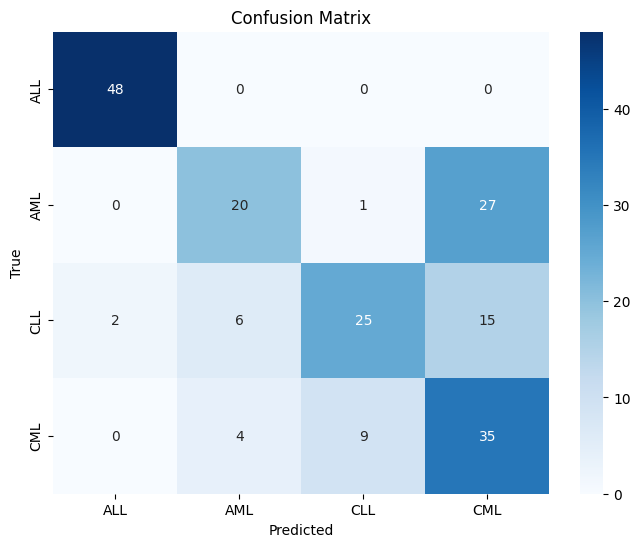

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    logging.info("--- Classification Report ---")
    report = classification_report(y_true, y_pred, target_names=loader.dataset.classes)
    print(report) # Print to console for better formatting
    logging.info(f'\n{report}') # Log the report
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=loader.dataset.classes, yticklabels=loader.dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Load the best baseline model and evaluate it
best_baseline_model = models.resnet18()
num_ftrs = best_baseline_model.fc.in_features
best_baseline_model.fc = nn.Linear(num_ftrs, len(CLASSES))
best_baseline_model.load_state_dict(torch.load(MODEL_DIR / 'baseline_cls.pt'))

logging.info("--- Evaluating Baseline Model on Test Set ---")
evaluate_model(best_baseline_model, test_dl)

# Step 7: Make it Smarter with GA (Genetic Algorithm)

This is where metaheuristics come in. We will use a Genetic Algorithm (GA) to find the best hyperparameters for our model, such as the learning rate and weight decay.

**This is a simplified stub to show the structure. A full run can take a very long time.**

In [24]:
from deap import base, creator, tools, algorithms
import random

LR_BOUNDS = [1e-5, 1e-2]
WD_BOUNDS = [1e-5, 1e-2]

def eval_hyperparameters(individual):
    lr = LR_BOUNDS[0] + (LR_BOUNDS[1] - LR_BOUNDS[0]) * individual[0]
    wd = WD_BOUNDS[0] + (WD_BOUNDS[1] - WD_BOUNDS[0]) * individual[1]
    
    logging.info(f"GA Evaluating - LR: {lr:.6f}, WD: {wd:.6f}")
    # Placeholder: In a real scenario, you'd implement a short training loop here and return the validation accuracy.
    fitness = random.random()
    logging.info(f"  -> Achieved fitness (mock): {fitness:.4f}")
    return (fitness,)

# Setup DEAP for GA
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", eval_hyperparameters)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run the GA
population = toolbox.population(n=10)
ngen = 5
cxpb = 0.5
mutpb = 0.2

logging.info("--- Starting Genetic Algorithm for Hyperparameter Tuning ---")
algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, verbose=True)

best_ind = tools.selBest(population, k=1)[0]
best_lr = LR_BOUNDS[0] + (LR_BOUNDS[1] - LR_BOUNDS[0]) * best_ind[0]
best_wd = WD_BOUNDS[0] + (WD_BOUNDS[1] - WD_BOUNDS[0]) * best_ind[1]

logging.info("--- Genetic Algorithm Finished ---")
logging.info(f"Best Individual's Fitness = {best_ind.fitness.values[0]:.4f}")
logging.info(f"Optimal Learning Rate = {best_lr:.6f}")
logging.info(f"Optimal Weight Decay = {best_wd:.6f}")

/Users/adarshainamdar/Documents/Major_Project/.venv/lib/python3.13/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/adarshainamdar/Documents/Major_Project/.venv/lib/python3.13/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
2025-09-04 12:27:12,766 - INFO - --- Starting Genetic Algorithm for Hyperparameter Tuning ---
2025-09-04 12:27:12,767 - INFO - GA Evaluating - LR: 0.003304, WD: 0.005584
2025-09-04 12:27:12,768 - INFO -   -> Achieved fitness (mock): 0.1278
2025-09-04 12:27:12,768 - INFO - GA Evaluating - LR: 0.003872, WD: 0.002527
2025-09-04 12:27:1

gen	nevals
0  	10    
1  	3     
2  	7     
3  	4     
4  	7     
5  	5     


# Step 8: Add Explainability (Grad-CAM)

To build trust with clinicians, we can show them *why* our model made a certain prediction. **Grad-CAM** creates a heatmap highlighting the regions of the input image that were most important for the model's decision.

2025-09-04 12:27:22,718 - INFO - Generating Grad-CAM visualization...


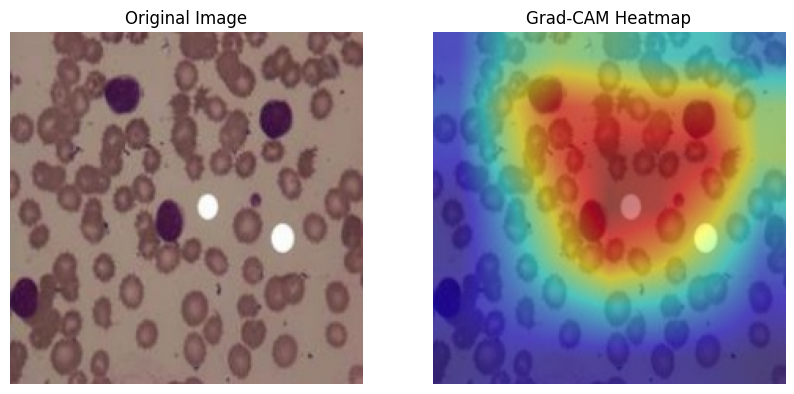

2025-09-04 12:27:22,873 - INFO - Grad-CAM visualization generated successfully.


In [25]:
!pip install grad-cam

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image

def generate_grad_cam(model, target_layer, input_tensor, original_image, target_category=None):
    cam = GradCAM(model=model, target_layers=[target_layer])
    targets = [ClassifierOutputTarget(target_category)] if target_category is not None else None
    grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0), targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(np.array(original_image) / 255.0, grayscale_cam, use_rgb=True)
    return visualization

logging.info("Generating Grad-CAM visualization...")
try:
    test_image_path = next(TEST_DIR.glob('ALL/*.jpg')) # Use next() to get first item safely
    original_img = Image.open(test_image_path).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE))
    input_tensor = tfm_eval(original_img)

    model_for_cam = best_baseline_model.to('cpu')
    target_layer = model_for_cam.layer4[-1]

    cam_image = generate_grad_cam(model_for_cam, target_layer, input_tensor, original_img)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    ax[1].imshow(cam_image)
    ax[1].set_title('Grad-CAM Heatmap')
    ax[1].axis('off')
    plt.show()
    logging.info("Grad-CAM visualization generated successfully.")
except StopIteration:
    logging.warning("Could not find a test image in 'ALL' class for Grad-CAM visualization. Skipping.")

# Next Steps

1.  **Full Metaheuristic Run**: Replace the `eval_hyperparameters` placeholder with a real (but short) training function and run the GA for more generations on a more powerful machine.
2.  **Train Final Model**: Use the best hyperparameters found by the GA to train your multi-task model fully on all the training data.
3.  **Build a Demo App**: Use a framework like Streamlit or Flask to create a simple web app where a user can upload a blood smear image and see the model's classification, grade prediction, and Grad-CAM heatmap.